In [2]:
import pandas as pd
import numpy as np
import joblib as jb
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

In [6]:
path = '../data/generated/df_newimages_bands_downside.pkl.z'

In [13]:
df = jb.load(path)
df.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,b2b4,b3b4,ndwi15,ndwi24,ndwi53,cspmb7
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,1.162614,1.094573,0.419775,0.302256,-0.152982,23.382784
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.0490,0.0316,0.0283,0.0237,1.171434,1.099318,0.419775,0.316380,-0.153713,23.382784
2,233,1132,3.299687,0.1199,0.0879,0.0666,0.0461,0.0488,0.0324,0.0281,0.0238,1.168473,1.096035,0.421458,0.311940,-0.154246,23.158824
3,233,1133,3.268182,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,1.175411,1.111754,0.421458,0.322339,-0.172881,23.158824
4,233,1134,3.278125,0.1196,0.0884,0.0677,0.0454,0.0489,0.0323,0.0285,0.0238,1.174645,1.104724,0.419585,0.321375,-0.161235,23.607309


<Figure size 864x432 with 0 Axes>

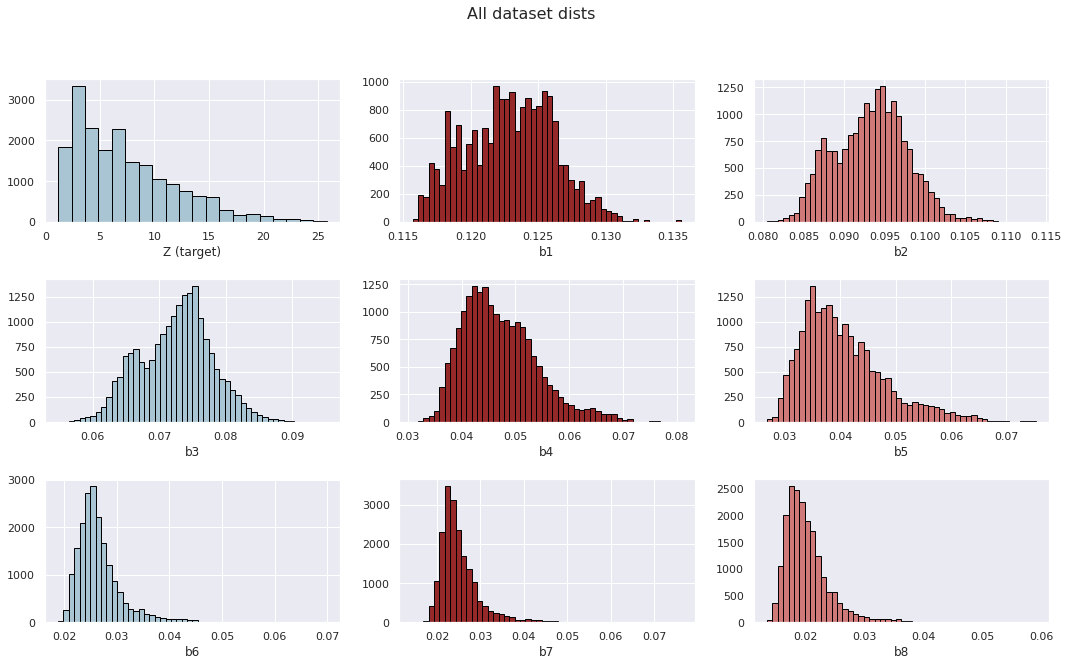

In [35]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 10))
_ = axs[0][0].hist(df.z, bins=20, color='#A9C5D3', edgecolor='black')
_ = axs[0][1].hist(df.b1, bins=50, color='#952828', edgecolor='black')
_ = axs[0][2].hist(df.b2, bins=50, color='#cf7979', edgecolor='black')
_ = axs[1][0].hist(df.b3, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[1][1].hist(df.b4, bins=50, color='#952828', edgecolor='black')
_ = axs[1][2].hist(df.b5, bins=50, color='#cf7979', edgecolor='black')
_ = axs[2][0].hist(df.b6, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[2][1].hist(df.b7, bins=50, color='#952828', edgecolor='black')
_ = axs[2][2].hist(df.b8, bins=50, color='#cf7979', edgecolor='black')
axs[0][0].set_xlabel('Z (target)')
axs[0][1].set_xlabel('b1')
axs[0][2].set_xlabel('b2')
axs[1][0].set_xlabel('b3')
axs[1][1].set_xlabel('b4')
axs[1][2].set_xlabel('b5')
axs[2][0].set_xlabel('b6')
axs[2][1].set_xlabel('b7')
axs[2][2].set_xlabel('b8')
plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
fig.suptitle('All dataset distributions', fontsize=16)
fig.savefig('charts/raw_bands_histogram.jpg')

In [ ]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

_ = sns.jointplot(df.z, df.ndwi53, ax=axs[0,0])
_ = sns.jointplot(df.z, df.ndwi24, ax=axs[0, 1])
_ =sns.jointplot(df.z, df.ndwi15, ax=axs[0, 2])
_ = sns.jointplot(df.z, df.b3b4, ax=axs[1, 0])
_ = sns.jointplot(df.z, df.b2b4, ax=axs[1, 1])
fig.suptitle('NDWI and LOG-Ratio - Z relationship', fontsize=16)

fig.savefig('charts/ndwi_logs_relation_z.jpg')

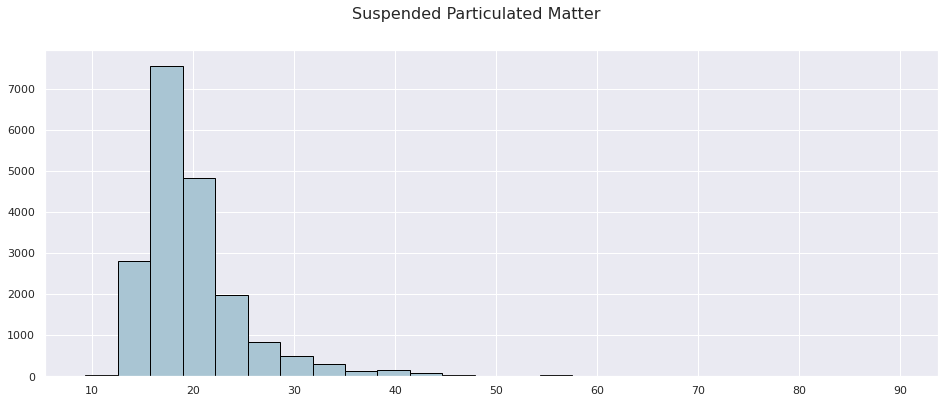

In [64]:
fig = plt.figure(figsize=(16,6))
_ = plt.hist(df.cspmb7, bins=25, color='#A9C5D3', edgecolor='black')
fig.suptitle('Suspended Particulated Matter', fontsize=16)
fig.savefig('charts/cspmb7.jpg')


In [68]:
only_bands = df[['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'z']]

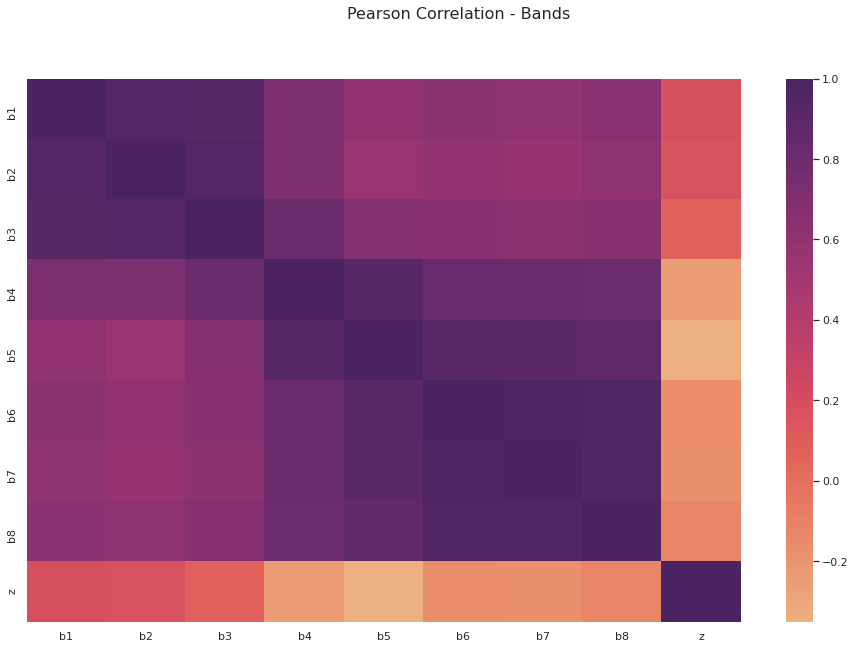

In [76]:
fig = plt.figure(figsize=(16, 10))
_ = sns.heatmap(only_bands.corr(), cmap='flare')
fig.suptitle('Pearson Correlation - Bands', fontsize=16)
fig.savefig('charts/pearson_corr_bands.jpg')


In [80]:
ndwi_and_logs = df[['b2b4', 'b3b4', 'ndwi15', 'ndwi24', 'ndwi53', 'z']]

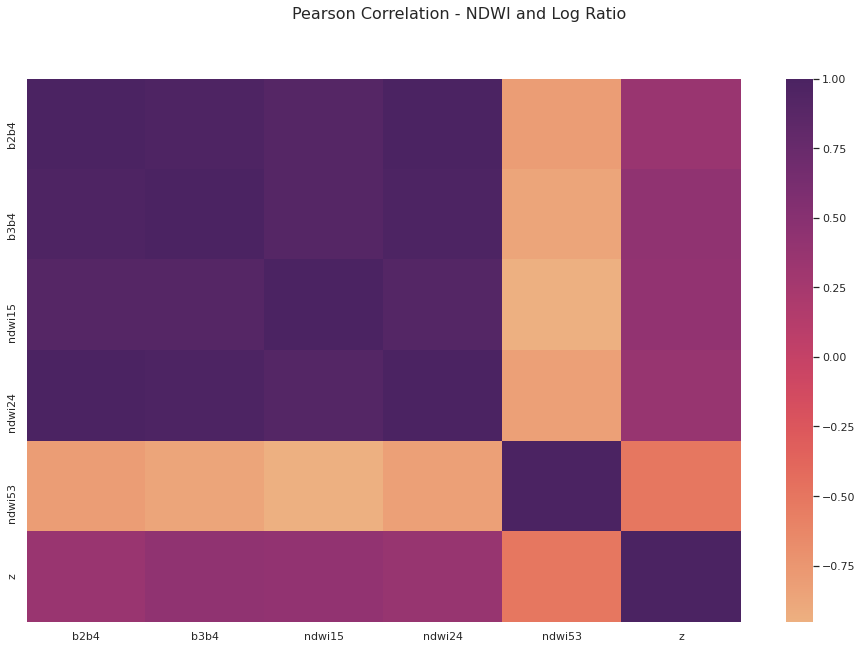

In [84]:
fig = plt.figure(figsize=(16, 10))
_ = sns.heatmap(ndwi_and_logs.corr(), cmap='flare')
fig.suptitle('Pearson Correlation - NDWI and Log Ratio', fontsize=16)
fig.savefig('charts/pearson_corr_ndwlogs.jpg')
